In [1]:
!rm -r track
!mkdir track

In [2]:
#!unzip ./drive/MyDrive/celebA/img_align_celeba.zip -d ./data

In [3]:
# Non Torch Imports
import os
import argparse
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import PIL

# Torch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.nn import functional as F
from torchvision.io import read_image
from torch.utils.data import Dataset

# Torch Vision Imports
from torchvision import transforms as T
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image

In [4]:
# Root directory for dataset
dataroot = "./data/img_align_celeba/"

# Number of workers for dataloader
workers = 8

# Batch size during training
batch_size = 1500

# Image Size
image_size = 64

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda')

In [7]:
torch.cuda.device_count()

1

In [8]:
!ls -ltrh ./data/img_align_celeba/ | head -5

total 1.7G
-rwxrwxrwx 1 root root 5.7K Sep 28  2015 000027.jpg
-rwxrwxrwx 1 root root 7.0K Sep 28  2015 000026.jpg
-rwxrwxrwx 1 root root 6.6K Sep 28  2015 000025.jpg
-rwxrwxrwx 1 root root 8.2K Sep 28  2015 000024.jpg


In [9]:
# Load the CelebA dataset
class CelebDataset(Dataset):
	def __init__(self, dataset_path, image_size):
		self.dataset_path = dataset_path
		self.imgs = []
		self.transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
		for dirpath, _, filenames in os.walk(self.dataset_path):
			self.imgs.extend([f"{dirpath}/{i}" for i in filenames if i.endswith('.jpg')])

	def __len__(self):
		# Returns the Size of the Dataset
		return len(self.imgs)

	def __getitem__(self, idx):
		# Returns a Sample from the data
		image = PIL.Image.open(self.imgs[idx])
		image = self.transform(image)
		return image

In [10]:
dataset = CelebDataset(dataroot, image_size)

In [11]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers,
                                         drop_last=True)


In [12]:
sample_batch = next(iter(dataloader))

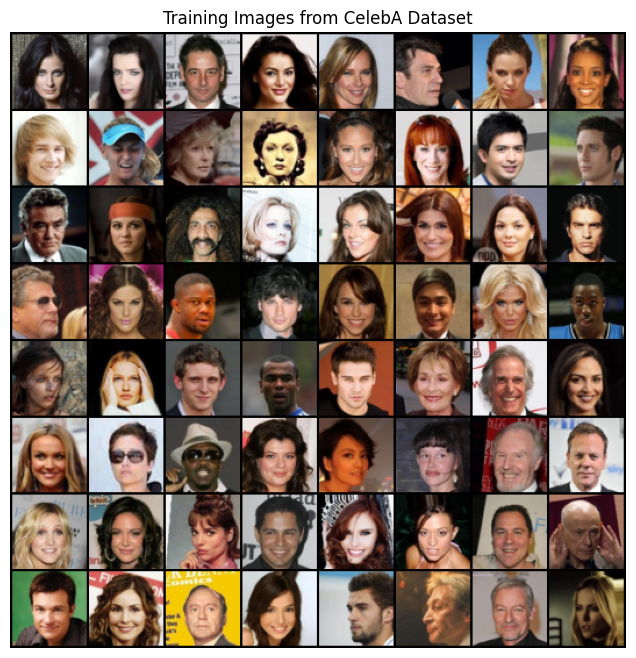

In [13]:
# Plot some training images
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images from CelebA Dataset")
plt.imshow(np.transpose(vutils.make_grid(sample_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.num_channels = 3
        self.num_disc_filter = 64
        self.main = nn.Sequential(
            # input is 3 x 64 x 64
          nn.Conv2d(self.num_channels, self.num_disc_filter,
                    kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # current size. 64 x 32 x 32
            nn.Conv2d(self.num_disc_filter, self.num_disc_filter * 2,
                      kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.num_disc_filter * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # current size. 128 x 16 x 16
            nn.Conv2d(self.num_disc_filter * 2, self.num_disc_filter * 4,
                      kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.num_disc_filter * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # current size. 256 x 8 x 8
            nn.Conv2d(self.num_disc_filter * 4, self.num_disc_filter * 8,
                      kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.num_disc_filter * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # current size. 512 x 4 x 4
            nn.Conv2d(self.num_disc_filter * 8, 1,
                      kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [15]:
D = Discriminator()

In [16]:
input = torch.randn((1, 3, 64, 64))
D(input)

tensor([[[[0.5634]]]], grad_fn=<SigmoidBackward0>)

In [17]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.nz = 100
        self.output_channels = 3
        self.num_gen_filters = 64
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(self.nz, self.num_gen_filters * 8,
                               kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(self.num_gen_filters * 8),
            nn.ReLU(True),
            # output size. 512 x 4 x 4
            nn.ConvTranspose2d(self.num_gen_filters * 8, self.num_gen_filters * 4,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.num_gen_filters * 4),
            nn.ReLU(True),
            # output size. 256 x 8 x 8
            nn.ConvTranspose2d(self.num_gen_filters * 4, self.num_gen_filters * 2,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.num_gen_filters * 2),
            nn.ReLU(True),
            # output size. 128 x 16 x 16
            nn.ConvTranspose2d(self.num_gen_filters * 2, self.num_gen_filters,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.num_gen_filters),
            nn.ReLU(True),
            # output size. 64 x 32 x 32
            nn.ConvTranspose2d(self.num_gen_filters, self.output_channels,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # final size. 3 x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [18]:
G = Generator()

In [19]:
input = torch.randn((1, 100, 1, 1))
G(input).shape

torch.Size([1, 3, 64, 64])

In [20]:
# custom weights initialization called on G and D
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [21]:
# Create the generator
G = Generator().to(device)
G.apply(weights_init)

# Create the Discriminator
D = Discriminator().to(device)
D.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [22]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()
lr = 0.0005 # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparameter for Adam optimizers
nz = 100 # 100 dimensional noise

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, 100, 1, 1, device=device)

# Setup Adam optimizers for both G and D
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

In [23]:
def train_discriminator(face_data_batch):
    #===================Discriminator-Trainer===================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = face_data_batch, torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
    x_real, y_real = x_real.to(device), y_real.to(device)

    # Loss for Real MNIST Data
    D_output = D(x_real).view(-1)
    D_real_loss = criterion(D_output, y_real)

    # Generate Data from Generator Network for Training
    #z = torch.randn(batch_size, z_dim).to(device) # Random Noise as Input to G
    x_fake, y_fake = G(fixed_noise), torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

    # Loss for Fake Data from Generator
    D_output = D(x_fake).view(-1)
    D_fake_loss = criterion(D_output, y_fake)

    # Updating only D's weights, so training on D on total loss
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()

    return  D_loss.data.item()


In [24]:
def train_generator():
    #=======================Generator-Trainer=======================#
    G.zero_grad()

    # Generate Random Noise to use as Input to the Generator
    # z = torch.randn(batch_size, z_dim).to(device)
    # The final label in this case in 1(True), i.e the Discriminator Model
    # Thinks these are real images therefore the losses for Generator
    # Network should update the weights of G in such a way that it produces more
    # Real looking images.
    y = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)

    # Generate Images
    G_output = G(fixed_noise)
    # Get output from Discriminator for the Generated Images
    D_output = D(G_output).view(-1)
    # Compute Loss
    G_loss = criterion(D_output, y)

    # Updating only G's weights
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()


In [ ]:
# Total number of epochs for Training
n_epoch = 200
n_critic = 2
losses = []

for epoch in range(n_epoch):
    D_losses, G_losses = [], []
    # For Every Batch in the MNIST dataset
    # We train the Discriminator First, then the Generator
    for batch_idx, face_data_batch in enumerate(dataloader):
        # print(face_data_batch.shape)
        for _ in range(n_critic):
          D_losses.append(train_discriminator(face_data_batch))
        G_losses.append(train_generator())

    if epoch % 1 == 0:
        ix = torch.randint(0, batch_size, (8,)).to(device)
        test_z = fixed_noise[ix,:,:,:]
        generated = G(test_z)
        save_image(generated.view(generated.size(0), 3, 64, 64), f'./track/sample_images_{epoch}' + '.png')

    # Logging the Loss values from Discriminator and Generator
    loss_d = torch.mean(torch.FloatTensor(D_losses))
    loss_g = torch.mean(torch.FloatTensor(G_losses))
    losses.append((loss_d, loss_g))
    print(f'[{epoch}/{n_epoch}]: loss_d: {loss_d}, loss_g: {loss_g}')

[0/200]: loss_d: 0.7786408066749573, loss_g: 7.960068702697754
[1/200]: loss_d: 0.7095332145690918, loss_g: 4.8464837074279785
[2/200]: loss_d: 0.7147655487060547, loss_g: 4.254202842712402
[3/200]: loss_d: 0.7720344662666321, loss_g: 2.7423291206359863
[4/200]: loss_d: 0.8680962324142456, loss_g: 1.5249649286270142
[5/200]: loss_d: 1.0295289754867554, loss_g: 0.9820353388786316
[6/200]: loss_d: 1.119287133216858, loss_g: 0.7712846398353577
[7/200]: loss_d: 1.1718348264694214, loss_g: 0.7285061478614807
[8/200]: loss_d: 1.21906578540802, loss_g: 0.725246787071228
[9/200]: loss_d: 1.2460156679153442, loss_g: 0.7660753726959229
